In [1]:
import torch
from torch.nn import DataParallel, Linear
import torchvision
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
import numpy as np
import  matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline


### Load MNIST Data

In [2]:
mnist_train = torchvision.datasets.MNIST(root = './MNIST_data',train=True,download=True)
mnist_train

#A dataset returning pil image and label for each __getitem__ call
print(mnist_train)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 14241615.71it/s]                           


Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 211290.46it/s]           
0it [00:00, ?it/s]

Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 3741726.62it/s]                           
8192it [00:00, 82859.24it/s]


Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!
Dataset MNIST
    Number of datapoints: 60000
    Root location: ./MNIST_data
    Split: Train


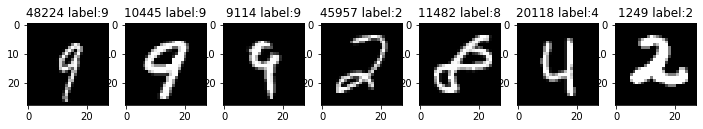

In [3]:
plt.figure(figsize = (12,20))
count = 7
for i in range(count):
    plt.subplot(1,count,i+1)
    index = np.random.randint(0,len(mnist_train),(1,))[0]
    im_array = np.asarray(mnist_train[index][0])
    label = mnist_train[index][1]
    imshow(im_array,cmap='gray',)
    plt.title(str(index) + ' label:'+str(label))

### Convert Images to array

In [4]:
class MyDataset(Dataset):
    def __init__(self, mnist_dataset):
        super(MyDataset,self).__init__()
        self.mnist_dataset = mnist_dataset
    def __getitem__(self, index):
        item = self.mnist_dataset[index]
        image = item[0]
        label = item[1]
        image_array = np.array(image,dtype = np.float32).reshape((-1))/255
        return image_array, label
    def __len__(self):
        return len(self.mnist_dataset)

In [5]:
train_ds = MyDataset(mnist_train)
print(train_ds[0][0].shape,train_ds[0][1])
train_ds[0][0][200:250],train_ds[0][1]

(784,) 5


(array([0.        , 0.        , 0.        , 0.19215687, 0.93333334,
        0.99215686, 0.99215686, 0.99215686, 0.99215686, 0.99215686,
        0.99215686, 0.99215686, 0.99215686, 0.9843137 , 0.3647059 ,
        0.32156864, 0.32156864, 0.21960784, 0.15294118, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.07058824, 0.85882354, 0.99215686, 0.99215686,
        0.99215686, 0.99215686, 0.99215686, 0.7764706 , 0.7137255 ,
        0.96862745, 0.94509804, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       dtype=float32), 5)

## Args

In [6]:
import argparse
args = argparse.Namespace(
    batch = 16,
    lr = 0.001,
    epochs =1
)
args

Namespace(batch=16, epochs=1, lr=0.001)

## Model

In [7]:
class LinearModel(torch.nn.Module):
    def __init__(self, input_size, output_size, verbose = False):
        super(LinearModel,self).__init__()
        self.fc1 = torch.nn.Linear(input_size,64)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(64,output_size)
        self.verbose = verbose
    def forward(self, X):
        
        if self.verbose:
            print('X shape = {}, current cuda device = {}' \
                  .format(X.shape,torch.cuda.current_device() if torch.cuda.is_available() else 'NAN'))
        return self.fc2(self.relu(self.fc1(X)))

In [8]:
m = LinearModel(784,10,True)
m(torch.Tensor(train_ds[0][0]))

X shape = torch.Size([784]), current cuda device = 0


tensor([-0.0945,  0.0790, -0.2225, -0.1946,  0.0569,  0.0140, -0.0683,  0.0222,
        -0.0640, -0.0826], grad_fn=<AddBackward0>)

## DataLoader

In [9]:
dataloader = DataLoader(train_ds, batch_size=args.batch)

In [10]:
#converts arrays into tensor and creates batches
for data in dataloader:
    print(data)
    #print(model(data[0]))
    break

[tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7])]


## Train

In [11]:
from tqdm import tqdm
def train(model, optimizer, dataloader, device):
    model.train()
    print('using device',device)
    losses = []
    for epoch in range(args.epochs):
        for x,y in tqdm(dataloader, position=0):
            optimizer.zero_grad()
            x = x.to(device)
            y = y.to(device)
            
            yhat = model(x)
            
            loss = torch.nn.CrossEntropyLoss()(yhat, y)

            loss.backward()

            optimizer.step()
            losses.append(loss.item())
            
        print ('loss at epoch {} is {}'.format(epoch, losses[-1]))
        for param in model.parameters():
            print(param)

## CPU

In [12]:
model = LinearModel(784,10)
optimizer = torch.optim.Adam(params = model.parameters(), lr=args.lr)

In [13]:
%%time
cpu = torch.device('cpu')
train(model,optimizer,dataloader, cpu)

  0%|          | 0/3750 [00:00<?, ?it/s]

using device cpu


100%|██████████| 3750/3750 [00:18<00:00, 198.99it/s]

loss at epoch 0 is 0.018809974193572998
Parameter containing:
tensor([[-0.0282,  0.0239,  0.0053,  ..., -0.0080, -0.0225,  0.0338],
        [-0.0121, -0.0017,  0.0047,  ..., -0.0148,  0.0015,  0.0313],
        [ 0.0124,  0.0029, -0.0067,  ...,  0.0352, -0.0226, -0.0337],
        ...,
        [ 0.0127,  0.0104, -0.0105,  ...,  0.0155, -0.0187, -0.0217],
        [-0.0350, -0.0055,  0.0135,  ...,  0.0355,  0.0095, -0.0082],
        [ 0.0154,  0.0283,  0.0326,  ..., -0.0162, -0.0079, -0.0212]],
       requires_grad=True)
Parameter containing:
tensor([-0.0768, -0.0854, -0.0778,  0.0919,  0.0030,  0.2499, -0.1261, -0.0618,
         0.0997, -0.0397,  0.0349, -0.1766,  0.1634,  0.0301,  0.1412,  0.0241,
         0.2256,  0.1115, -0.0461,  0.0187, -0.1539,  0.0270,  0.0043, -0.0691,
         0.0558,  0.0656, -0.0333,  0.0047, -0.1608, -0.0123, -0.0189,  0.0366,
        -0.0263, -0.0634, -0.0687,  0.1254, -0.0778, -0.0655,  0.0036, -0.0768,
         0.2181, -0.0484,  0.0725,  0.1896,  0.0620,  0

## GPU 

In [14]:
gpu = torch.device('cuda')
model = LinearModel(784,10)
model = model.to(gpu)
dataloader = DataLoader(train_ds,batch_size=args.batch)
optimizer = torch.optim.Adam(params = model.parameters(), lr=args.lr)

%time train(model, optimizer, dataloader, gpu)

  0%|          | 1/3750 [00:00<10:02,  6.22it/s]

using device cuda


100%|██████████| 3750/3750 [00:10<00:00, 343.81it/s]


loss at epoch 0 is 0.02160853147506714
Parameter containing:
tensor([[ 0.0144, -0.0056,  0.0202,  ...,  0.0184,  0.0288,  0.0158],
        [-0.0348, -0.0038, -0.0159,  ..., -0.0275, -0.0320, -0.0029],
        [ 0.0001,  0.0311,  0.0231,  ..., -0.0039, -0.0227, -0.0015],
        ...,
        [ 0.0031,  0.0340,  0.0298,  ...,  0.0060, -0.0018, -0.0222],
        [-0.0172,  0.0206,  0.0066,  ...,  0.0064, -0.0346, -0.0296],
        [ 0.0290, -0.0145, -0.0155,  ...,  0.0103,  0.0070, -0.0222]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 0.1380,  0.0642, -0.0092,  0.0046,  0.0198,  0.2525,  0.1475,  0.0672,
         0.0433,  0.1507, -0.0757, -0.0282, -0.0282, -0.1713, -0.0778,  0.1163,
         0.1871,  0.0630,  0.1163,  0.3615, -0.1441, -0.1001, -0.0532,  0.0397,
         0.0834, -0.0422,  0.0019,  0.1109,  0.1919, -0.1069, -0.0486, -0.1045,
         0.0707, -0.0509, -0.1222, -0.0036,  0.1227, -0.1264,  0.0935, -0.0079,
        -0.0700,  0.1036, -0.1140, -0.0

#### Higher batch size

In [15]:

dataloader = DataLoader(train_ds,batch_size=args.batch *4)
optimizer = torch.optim.Adam(params = model.parameters(), lr=args.lr*4)
%time train(model, optimizer, dataloader, gpu)

  0%|          | 0/938 [00:00<?, ?it/s]

using device cuda


100%|██████████| 938/938 [00:06<00:00, 153.99it/s]

loss at epoch 0 is 0.02466443181037903
Parameter containing:
tensor([[ 0.0144, -0.0056,  0.0202,  ...,  0.0184,  0.0288,  0.0158],
        [-0.0348, -0.0038, -0.0159,  ..., -0.0275, -0.0320, -0.0029],
        [ 0.0001,  0.0311,  0.0231,  ..., -0.0039, -0.0227, -0.0015],
        ...,
        [ 0.0031,  0.0340,  0.0298,  ...,  0.0060, -0.0018, -0.0222],
        [-0.0172,  0.0206,  0.0066,  ...,  0.0064, -0.0346, -0.0296],
        [ 0.0290, -0.0145, -0.0155,  ...,  0.0103,  0.0070, -0.0222]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 0.2082, -0.0493, -0.0092, -0.0659, -0.0102,  0.2911,  0.1645,  0.1115,
         0.0175,  0.2169, -0.1462, -0.0282, -0.0393, -0.2371, -0.1923,  0.0631,
         0.2444,  0.0855,  0.0938,  0.4658, -0.2426, -0.1398, -0.0628, -0.0367,
         0.0546, -0.0422, -0.0458,  0.2201,  0.2209, -0.1406, -0.0745, -0.1477,
         0.0722, -0.0770, -0.1561, -0.0244,  0.0923, -0.1770,  0.2482, -0.0263,
        -0.1039,  0.0657, -0.1865, -0.0

## DataParallel
single process, multiple GPUs

    This container parallelizes the application of the given :attr:`module` by
    splitting the input across the specified devices by chunking in the batch
    dimension (other objects will be copied once per device). In the forward
    pass, the module is replicated on each device, and each replica handles a
    portion of the input. During the backwards pass, gradients from each replica
    are summed into the original module.

Source: https://pytorch.org/docs/stable/_modules/torch/nn/parallel/data_parallel.html

The batch size should be larger than the number of GPUs used.


1. This is not very optimal as every forward run transfers the model and data portion between GPUs. 
1. Unless the processing in the module takes significant amount of time, this is not very useful.
1. This is even slower than single GPU for simpler neural nets.

        inputs, kwargs = self.scatter(inputs, kwargs, self.device_ids)
        if len(self.device_ids) == 1:
            return self.module(*inputs[0], **kwargs[0])
        replicas = self.replicate(self.module, self.device_ids[:len(inputs)])
        outputs = self.parallel_apply(replicas, inputs, kwargs)
        return self.gather(outputs, self.output_device)

Issues : https://medium.com/huggingface/training-larger-batches-practical-tips-on-1-gpu-multi-gpu-distributed-setups-ec88c3e51255

In [16]:
model = LinearModel(784,10,verbose = False).to(gpu)
model = torch.nn.DataParallel(model)

#Each batch is split into number of gpus and data is scattered. Use verbose = True to verify parallel processing
dataloader = DataLoader(train_ds,batch_size=args.batch)
optimizer = torch.optim.Adam(params = model.parameters(), lr=args.lr)

%time train(model, optimizer, dataloader, gpu)

  0%|          | 0/3750 [00:00<?, ?it/s]

using device cuda


100%|██████████| 3750/3750 [00:28<00:00, 130.52it/s]

loss at epoch 0 is 0.02045580744743347
Parameter containing:
tensor([[-0.0076, -0.0294,  0.0116,  ..., -0.0147, -0.0065,  0.0233],
        [ 0.0011, -0.0171,  0.0117,  ..., -0.0304,  0.0206, -0.0230],
        [ 0.0346, -0.0024, -0.0289,  ...,  0.0125,  0.0123,  0.0176],
        ...,
        [-0.0225, -0.0271,  0.0311,  ..., -0.0336,  0.0192, -0.0331],
        [ 0.0084,  0.0030, -0.0014,  ...,  0.0080, -0.0274, -0.0197],
        [-0.0115, -0.0345,  0.0073,  ..., -0.0159, -0.0313,  0.0245]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 0.0054,  0.0412,  0.1164,  0.2572,  0.1048, -0.0464,  0.0366,  0.0670,
        -0.0300,  0.1368,  0.0753, -0.0254,  0.0471,  0.2325, -0.0971, -0.0404,
        -0.0392, -0.0520,  0.0278,  0.0607,  0.0581,  0.0866, -0.0204, -0.0930,
        -0.0066, -0.0504,  0.1568,  0.0442,  0.0608,  0.0227,  0.0414, -0.0266,
        -0.0021,  0.0406,  0.2628, -0.0318,  0.0794, -0.0016, -0.0291,  0.0027,
         0.1672,  0.1766, -0.1432, -0.0

#### Using Higher batch size
Even for higher batch sizes, it's still slower than single GPU

In [76]:
#Batch size can be increased to take advantage of the parallel processing
dataloader = DataLoader(train_ds,batch_size=args.batch *4)
#increase the lr for high batch size. (Provide proof for this)
optimizer = torch.optim.Adam(params = model.parameters(), lr=args.lr * 4)

%time train(model, optimizer, dataloader, gpu)

  1%|▏         | 12/938 [00:00<00:08, 110.95it/s]

using device cuda


100%|██████████| 938/938 [00:08<00:00, 110.32it/s]

loss at epoch 0 is 0.02199617028236389
CPU times: user 9.62 s, sys: 620 ms, total: 10.2 s
Wall time: 8.5 s
